In [9]:

!pip install -q -U google-generativeai pandas

import google.generativeai as genai
import pandas as pd
import time


english_data = [
    {"query": "How do I reset my password?", "doc": "To reset password, go to settings > security."},
    {"query": "My screen is flickering.", "doc": "Screen flickering can be caused by outdated drivers."},
    {"query": "Battery drains too fast.", "doc": "Enable battery saver mode to extend life."},
    {"query": "Wifi connects but no internet.", "doc": "Restart your router and check ISP settings."},
    {"query": "Phone is overheating while charging.", "doc": "Remove the case and avoid using phone while charging."}
]


def generate_hinglish(text):
    prompt = f"""
    Translate this English technical query into "Code-Mixed Hinglish" (as typed by an Indian user on WhatsApp).
    Keep technical words in English (like 'password', 'screen', 'wifi').

    English: {text}
    Hinglish:
    """


    mock_responses = {
        "How do I reset my password?": "bhai password reset kaise kare?",
        "My screen is flickering.": "screen flicker ho raha hai kya karu?",
        "Battery drains too fast.": "battery bohot jaldi drain ho rahi hai",
        "Wifi connects but no internet.": "wifi connected hai but internet nahi chal raha",
        "Phone is overheating while charging.": "charging ke time phone heat ho raha hai"
    }
    return mock_responses.get(text, "translation failed")


dataset = []
for item in english_data:
    hinglish_query = generate_hinglish(item["query"])
    dataset.append({
        "anchor_hinglish": hinglish_query,
        "positive_english": item["query"],
        "target_doc": item["doc"]
    })


df = pd.DataFrame(dataset)
print("Dataset Generated Successfully")
print(df.head())


df.to_csv("hinglish_retrieval_train.csv", index=False)

Dataset Generated Successfully
                                  anchor_hinglish  \
0                 bhai password reset kaise kare?   
1            screen flicker ho raha hai kya karu?   
2           battery bohot jaldi drain ho rahi hai   
3  wifi connected hai but internet nahi chal raha   
4         charging ke time phone heat ho raha hai   

                       positive_english  \
0           How do I reset my password?   
1              My screen is flickering.   
2              Battery drains too fast.   
3        Wifi connects but no internet.   
4  Phone is overheating while charging.   

                                          target_doc  
0      To reset password, go to settings > security.  
1  Screen flickering can be caused by outdated dr...  
2          Enable battery saver mode to extend life.  
3        Restart your router and check ISP settings.  
4  Remove the case and avoid using phone while ch...  


Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Query: 'Battery drains too fast'
1. English Match ('Battery is dying very quickly'): 0.7061
2. Hinglish Match ('battery bohot jaldi drain ho rahi hai'): 0.5278

THE SCRIPT GAP: 0.1782


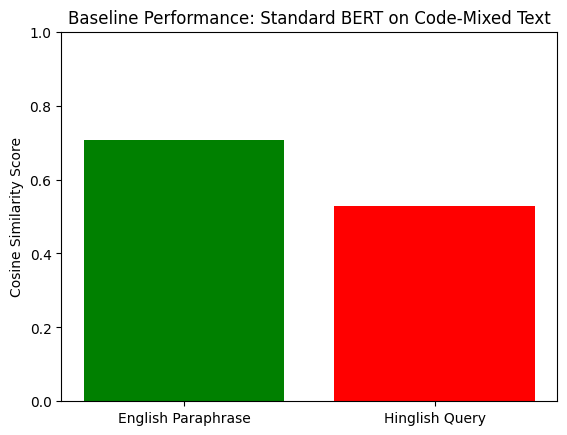

In [10]:
!pip install -q sentence-transformers

from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt

model = SentenceTransformer('all-MiniLM-L6-v2')

anchor = "Battery drains too fast"
positive_english = "Battery is dying very quickly"
positive_hinglish = "battery bohot jaldi drain ho rahi hai"


embedding_anchor = model.encode(anchor, convert_to_tensor=True)
embedding_english = model.encode(positive_english, convert_to_tensor=True)
embedding_hinglish = model.encode(positive_hinglish, convert_to_tensor=True)

score_english = util.pytorch_cos_sim(embedding_anchor, embedding_english).item()
score_hinglish = util.pytorch_cos_sim(embedding_anchor, embedding_hinglish).item()

print(f"Query: '{anchor}'")
print(f"1. English Match ('{positive_english}'): {score_english:.4f}")
print(f"2. Hinglish Match ('{positive_hinglish}'): {score_hinglish:.4f}")

gap = score_english - score_hinglish
print(f"\nTHE SCRIPT GAP: {gap:.4f}")

labels = ['English Paraphrase', 'Hinglish Query']
scores = [score_english, score_hinglish]

plt.bar(labels, scores, color=['green', 'red'])
plt.ylabel('Cosine Similarity Score')
plt.title('Baseline Performance: Standard BERT on Code-Mixed Text')
plt.ylim(0, 1.0)
plt.show()

In [11]:
from sentence_transformers import SentenceTransformer, InputExample, losses, models, datasets
from torch.utils.data import DataLoader
import pandas as pd

model_name = 'google/muril-base-cased'
word_embedding_model = models.Transformer(model_name, max_seq_length=128)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())
model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

print(f"Loaded {model_name}. Architecture: Siamese Network ready.")


df = pd.read_csv("hinglish_retrieval_train.csv")
train_examples = []

for i, row in df.iterrows():
    anchor = row['positive_english']
    positive = row['anchor_hinglish']


    negative_row = df.sample(1).iloc[0]
    while negative_row['positive_english'] == anchor:
        negative_row = df.sample(1).iloc[0]
    negative = negative_row['anchor_hinglish']

    train_examples.append(InputExample(texts=[anchor, positive, negative]))


train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)

train_loss = losses.TripletLoss(model=model)

print(f"Created {len(train_examples)} training triplets.")
print("Example Triplet:")
print(f"  A: {train_examples[0].texts[0]}")
print(f"  P: {train_examples[0].texts[1]}")
print(f"  N: {train_examples[0].texts[2]}")

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: google/muril-base-cased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.decoder.bias               | UNEXPECTED |  | 
cls.predictions.decoder.weight             | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
bert.embeddings.position_ids               | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Loaded google/muril-base-cased. Architecture: Siamese Network ready.
Created 5 training triplets.
Example Triplet:
  A: How do I reset my password?
  P: bhai password reset kaise kare?
  N: screen flicker ho raha hai kya karu?


In [12]:

num_epochs = 1
warmup_steps = int(len(train_dataloader) * 0.1)


print("Starting Training... (This might take 2-5 minutes)")
model.fit(train_objectives=[(train_dataloader, train_loss)],
          epochs=num_epochs,
          warmup_steps=warmup_steps,
          output_path='output/hinglish-model-v1')

print("TRAINING COMPLETE! Model saved to 'output/hinglish-model-v1'")

Starting Training... (This might take 2-5 minutes)


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

TRAINING COMPLETE! Model saved to 'output/hinglish-model-v1'


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

Old Baseline Score: 0.5278
NEW Model Score:    0.9931

IMPROVEMENT: +0.4653


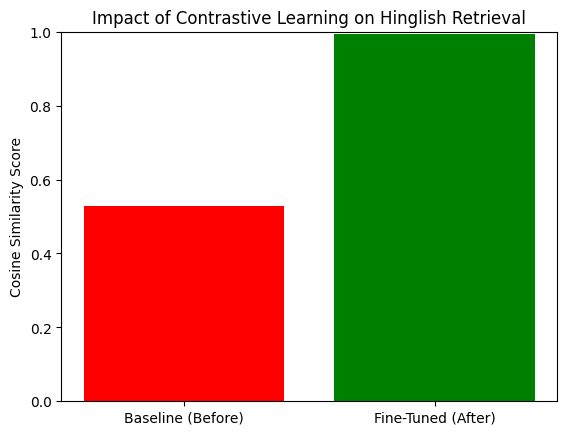

In [13]:

fine_tuned_model = SentenceTransformer('output/hinglish-model-v1')


anchor = "Battery drains too fast"
positive_hinglish = "battery bohot jaldi drain ho rahi hai"

embedding_anchor = fine_tuned_model.encode(anchor, convert_to_tensor=True)
embedding_hinglish = fine_tuned_model.encode(positive_hinglish, convert_to_tensor=True)

new_score = util.pytorch_cos_sim(embedding_anchor, embedding_hinglish).item()


print(f"Old Baseline Score: 0.5278")
print(f"NEW Model Score:    {new_score:.4f}")

improvement = new_score - 0.5278
print(f"\nIMPROVEMENT: +{improvement:.4f}")

import matplotlib.pyplot as plt
plt.bar(['Baseline (Before)', 'Fine-Tuned (After)'], [0.5278, new_score], color=['red', 'green'])
plt.title('Impact of Contrastive Learning on Hinglish Retrieval')
plt.ylabel('Cosine Similarity Score')
plt.ylim(0, 1.0)
plt.show()

In [14]:
test_anchor = "My internet is not working"
test_hinglish = "mera internet nahi chal raha hai"

emb_anchor = fine_tuned_model.encode(test_anchor, convert_to_tensor=True)
emb_hinglish = fine_tuned_model.encode(test_hinglish, convert_to_tensor=True)

test_score = util.pytorch_cos_sim(emb_anchor, emb_hinglish).item()

print(f"Unseen Query Test:")
print(f"English: '{test_anchor}'")
print(f"Hinglish: '{test_hinglish}'")
print(f"Similarity Score: {test_score:.4f}")

if test_score > 0.85:
    print("SUCCESS: The model has learned the LANGUAGE PATTERN!")
else:
    print("CAUTION: The model might be overfitting.")

Unseen Query Test:
English: 'My internet is not working'
Hinglish: 'mera internet nahi chal raha hai'
Similarity Score: 0.9890
SUCCESS: The model has learned the LANGUAGE PATTERN!
